# Lab Report 1 - Path to Philosophy

LT Number: 2

Names:<br>
Balagon, Val Anthony<br>
Borromeo, Chloe<br>
Dorado, Joshua Renzo<br>
Tallo, Francis


## Basic Goal

    Make a webcrawler that starts from a random Wikipedia page, and follows the first page link until it either finds the Philosophy page, a page with no links, or loops back to a previously visited link.
    
    Return the name of the starting page, and the degrees of separation from the Philosophy page (set degree to -1 if terminates otherwise)

        Ex. the page "Kevin Bacon" should have a degree of separation of 12
        
    NOTE: When crawling, put a time.sleep(1.25) after each iteration (don't get IP banned)

### Developed Code (webscraping via bs4 with short-circuit)

#### Imports & Secondary Functions

In [1]:
import os
import requests
import bs4
import numpy as np
import pandas as pd
from io import StringIO
from urllib.parse import urljoin, urlparse, unquote
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def get_parent(tag, pfr_list=True):
    """
    Retrieves the parent tag of a given HTML tag.
    It immediately returns the tag 'i' if found in the parent-finding.

    Parameters
    ----------
    tag : bs4.element.Tag
        The HTML tag whose parent is to be obtained.
    pfr_list : bool, optional
        If `True`, iterates through the primary tags (p, li, th, td) to find 
        the parent. If `False`, only returns the immediate parent.
        Defaults to True.

    Returns
    -------
    parent : bs4.element.Tag or None
        The parent tag of the input tag. Returns None if no parent is found.
    """

    parent = tag.parent
    if parent and parent.name == 'i':  # italics for exclusion later
        return parent
    parents = ['p', 'li', 'th', 'td']
    if pfr_list:  # if not usual container, just use the first parent
        while parent and parent.name not in parents:  # iterate until tag
            parent = parent.parent
            if parent and parent.name == 'i':  # italics for exclusion later
                return parent
    return parent


def enclosed(tag, pfr_list=True):
    """
    Checks if an HTML tag is enclosed within parentheses.

    Parameters
    ----------
    tag : bs4.element.Tag
        The HTML tag to be checked.
    pfr_list : bool, optional
        If `True`, considers the tag's immediate parent and its ancestors. If 
        `False`, only considers the immediate parent. Defaults to True.

    Returns
    -------
    bool
        True if the tag is enclosed within parentheses, False otherwise.
    """

    parent = get_parent(tag, pfr_list)
    if parent is None:
        return False  # not enclosed if no parent
    if parent.name == 'i':  # enclosed in italic tag
        return True
    parent_text = str(parent)  # includes the html tags
    tag_text = str(tag)  # includes the html tags
    idx = parent_text.index(tag_text)
    l_cnt = parent_text[:idx].count('(')
    r_cnt = parent_text[:idx].count(')')
    if l_cnt == 0 or l_cnt - r_cnt != 1:  # left ( not found, or no open left
        return False
    l_cnt = parent_text[idx+len(tag_text):].count('(')
    r_cnt = parent_text[idx+len(tag_text):].count(')')
    # print('right >> ' + parent_text[idx+len(tag_text):])
    if r_cnt == 0 or r_cnt - l_cnt != 1:  # right ( not found, or no open right
        return False
    return True  # enclosed


def online(alink, url):
    """
    Checks if an anchor link is online and accessible.

    Parameters
    ----------
    alink : bs4.element.Tag
        The anchor link tag to be checked.
    url : str
        The base URL to which the anchor link is appended.

    Returns
    -------
    bool
        True if the anchor link is accessible, False otherwise.
    """

    try:
        response = requests.get(urljoin(url, alink['href']))
    except Exception:
        return False
    if response.status_code == 200:
        return True
    return False


def wiki(alink, stop_words):
    """
    Checks if an anchor link is a valid Wikipedia link.

    Parameters
    ----------
    alink : bs4.element.Tag
        The anchor link tag to be checked.
    stop_words : list
        List of stop words to exclude invalid links.

    Returns
    -------
    bool
        True if the anchor link is a valid Wikipedia link, False otherwise.
    """

    link = alink['href']
    netloc = urlparse(link).netloc
    if netloc == '' or 'wikipedia.org' in netloc:
        return not any([word for word in stop_words if word in unquote(link)])
    return False


def get_link(body, stop_words, url):
    """
    Retrieves the first valid link within the primary tags (p, li, th, td)
    of the main body.

    Parameters
    ----------
    body : bs4.element.Tag
        The main content of the web page.
    stop_words : list
        List of stop words to exclude invalid links.
    url : str
        The base URL of the web page.

    Returns
    -------
    link : str
        The URL of the first valid link found.
    """

    link = ''
    a_str = ('a[href]:not([href^="#cite_note"]):not([href^="#"])'
             ':not(.mw-disambig)')
    p_str = ['p', 'li', 'th', 'td']
    alinks = body.select(', '.join([f'{p} {a_str} ' for p in p_str]))
    for alink in alinks:
        if (wiki(alink, stop_words) and online(alink, url)
                and not enclosed(alink)):
            link = alink['href']
            break
    return link


def get_other_link(body, extags, stop_words, url):
    """
    Retrieves a valid link from the main body if no valid links are found
    in get_link().

    Parameters
    ----------
    body : bs4.element.Tag
        The main content of the web page.
    extags : list
        List of extracted tags from the main content to be added back.
    stop_words : list
        List of stop words to exclude invalid links.
    url : str
        The base URL of the web page.

    Returns
    -------
    link : str
        The URL of another valid link found.

    Raises
    ------
    IndexError
        If no valid links are found.
    """

    link = ''
    a_str = ('a[href]:not([href^="#cite_note"]):not([href^="#"]):'
             'not(.mw-disambig)')
    for extag in extags:  # add back extracted tags for full search
        body.append(extag)
    alinks = body.select(f'{a_str}')
    for alink in alinks:
        if (wiki(alink, stop_words) and online(alink, url)
                and not enclosed(alink, False)):
            link = alink['href']
            break
    if link == '':  # no valid links in the body
        raise IndexError
    return link

def save_linkhist(linkhist, dir_, a, iter, fin=False):
    """
    Saves the Link:DoS history to a CSV file.

    Parameters
    ----------
    linkhist : dict
        Dictionary containing link:DoS mappings.
    dir_ : str
        Directory where the CSV file will be saved.
    a : int
        Starting index used in the filename for identification.
    iter : int
        Iteration number used in the filename for identification.
    fin : bool, optional
        If `True`, indicates the final save. Defaults to False.

    Returns
    -------
    None
    """

    dflhist = pd.DataFrame(list(linkhist.items()), columns=['Link', 'DoS'])
    buname = f'_bu{a:03d}.{iter:03d}' if not fin else ''
    dflhist.to_csv(f'{dir_}linkhist{buname}.csv', index=False)
    print(f'Link:DoS {"backup " if not fin else ""}history saved to {dir_}linkhist{buname}.csv')
    return None

def save_conso(data, dir_, a, iter, fin=False):
    """
    Saves consolidated crawl results to a CSV file.

    Parameters
    ----------
    data : list
        List containing crawl data entries.
    dir_ : str
        Directory where the CSV file will be saved.
    a : int
        Starting index used in the filename for identification.
    iter : int
        Iteration number used in the filename for identification.
    fin : bool, optional
        If `True`, indicates the final save. Defaults to False.

    Returns
    -------
    pandas.DataFrame or None
        Returns a DataFrame if `fin` is True; otherwise, returns None.
    """

    df = pd.DataFrame(data, columns=['Start', 'DoS', 'Path', 'Msg'])
    buname = '_bu' if not fin else ''
    df.to_csv(f'{dir_}conso{buname}{a:03d}.{iter:03d}.csv', index=False)
    print(f'Consolidated {"backup " if not fin else ""}results saved to '
          f'{dir_}conso{buname}{a:03d}.{iter:03d}.csv')
    return df if fin else None

#### Main Functions

In [4]:
def web_crawler(a, dir_, url=None, lang='en', linkhist={}):
    """
    This function starts from a random Wikipedia page and follows the first
    page link until it reaches the Philosophy page, a page with no links, or
    loops back to a previously visited link.
    This function accepts a link:DoS (linkhist) dictionary which shorts the
    path to Philosopy, removing redundant crawls from previous runs.

    Parameters
    ----------
    a : int
        Index for the web crawl.
    dir_ : str
        Directory path where the output scrape CSV file will be saved.
    url : str, optional
        The starting URL for the web crawl. If not provided, a random Wikipedia
        page URL will be chosen based on the specified language.
    lang : str, optional
        The language code for the Wikipedia pages. Defaults to 'en' (English).
        Other options: 'es' (Spanish), 'fr' (French), 'de' (German).
    linkhist : dict, optional
        Dictionary to store link history - used for the short path, reducing
        crawl iterations.

    Returns
    -------
    flinks : list
        List of visited page URLs during the crawl.
    dosl : list
        List of degrees of separation (DoS) for each visited page.
    msg : str
        Message indicating the status of the crawl (e.g., 'OK - normal path' or
        'NOK - no links found').

    Notes
    -----
    - The function excludes certain types of links (e.g., language links,
      disambiguation pages, external links) during the crawl.
    - It prioritizes links within specific HTML tags and considers the main tex
      of the Wikipedia page.
    - The DoS represents the number of steps from the starting page to the
      Philosophy page.
    - It outputs the single scrape result into a CSV file.

    Example
    -------
    flinks, dosl, msg = web_crawler(1, 'output/', lang='en')
    """

    if not bool(url):
        url = f'https://{lang}.wikipedia.org/wiki/Special:Random'
    philo = {
        'en': 'Philosophy',
        'de': 'Philosophie',
        'es': 'Psicología',
        'fr': 'Philosophie'
    }
    target = f'https://{lang}.wikipedia.org/wiki/{philo[lang]}'
    stop_words = {
        'en': ['Wikipedia:', 'Wikipedia talk:', 'User:', 'User_talk:', 'Talk:',
               'Help:', 'Help talk:', 'Project:', 'Project talk:',
               'Portal:', 'Portal talk:', 'Template:', 'Template talk:',
               'File:', 'File talk:', 'Special:', 'index.php',
               'Category:', 'Category talk:', 'Template_talk:', 'MOS:', 'Special:'],
        'de': ['Wikipedia:', 'Wikipedia Diskussion:', 'Benutzer:', 'Benutzer Diskussion:',
               'Diskussion:',
               'Hilfe:', 'Hilfe Diskussion:', 'Projekt:',
               'Projekt Diskussion:',
               'Portal:', 'Portal Diskussion:', 'Vorlage:',
               'Vorlage Diskussion:',
               'Datei:', 'Datei Diskussion:', 'Spezial:', 'index.php',
               'Kategorie:', 'Kategorie Diskussion:', 'Vorlage Diskussion:',
               'MOS:', 'Special:'],
        'es': ['Wikipedia:', 'Wikipedia discusión:', 'Usuario:', 'Usuario discusión:',
               'Discusión:',
               'Ayuda:', 'Ayuda discusión:', 'Wikiproyecto:', 'Wikiproyecto discusión:',
               'Portal:', 'Portal discusión:', 'Plantilla:', 'Plantilla discusión:',
               'Archivo:', 'Archivo discusión:', 'Especial:', 'index.php',
               'Categoría:', 'Categoría discusión:', 'Plantilla discusión:', 'WP:',
               'Special:'],
        'fr': ['Wikipédia:', 'Discussion Wikipédia:', 'Utilisateur:',
               'Discussion utilisateur:', 'Discussion:', 'Aide:', 'Discussion aide:',
               'Projet:', 'Discussion Projet:', 'Portail:', 'Discussion Portail:',
               'Modèle:', 'Discussion modèle:', 'Fichier:', 'Discussion fichier:',
               'Spécial:', 'index.php', 'Catégorie:', 'Discussion catégorie:',
               'Discussion modèle:', 'MOS:', 'Spécial:']

    }
    s = requests.Session()
    response = s.get(url)
    link = urlparse(response.url).path
    flink = urljoin(url, link)
    flinks = []
    flinks.append(flink)
    print(link)
    ldos = 0
    dos = -1
    msg = ''
    while True:
        response = s.get(flink)
        soup = bs4.BeautifulSoup(response.text)
        body = soup.find('div', id='bodyContent')
        # remove infobox, sidebar, etc. as sometimes they are first in the HTML structure
        for table in body.find_all('table', class_=['infobox', 'sidebar',
                                                    'metadata']):
            table.extract()
        for div in body.find_all('div', class_=['infobox', 'sidebar',
                                                'metadata']):
            div.extract()
        for div in body.find_all('div', role='note'):
            div.extract()
        # squash these elements - only use if there are no links found in main elements
        extags = []
        for extag in body.find_all('div', class_='thumbcaption'):
            extags.append(extag.extract())
        for extag in body.find_all('figcaption'):
            extags.append(extag.extract())
        for extag in body.find_all('table', class_=['infobox',
                                                    'standings-box']):
            extags.append(extag.extract())
        try:
            link = get_link(body, stop_words[lang], url)
            if link == '':  # no valid link within p, li, th, or td elements (main)
                link = get_other_link(body, extags, stop_words[lang], url)
            flink = urljoin(url, link)
        except IndexError:  # no valid links condition
            print('No valid links found in current page.')
            print(f'Failed to reach {philo[lang]}; DoS = -1.')
            msg = f'NOK - no links at {link} (last idx: {len(flinks)-1})'
            break
        if unquote(flink) == target:  # successfully reached target
            flinks.append(flink)
            print(link)
            print(f'Successfully reached {philo[lang]} w/ DoS '
                  f'= {len(flinks)-1}.')
            msg = 'OK - normal path.'
            break
        elif flink in flinks:  # looping condition
            print(f'Looped back to {link}.')
            print(f'Failed to reach {philo[lang]}; DoS = -1.')
            msg = (f'NOK - looped at {link} (link idx: {flinks.index(flink)}; '
                   f'last idx: {len(flinks)-1})')
            break
        else:  # valid link, and continue
            flinks.append(flink)
            print(link)
            if link in linkhist:  # short path if link was visited in previous crawls
                ldos = linkhist[link]
                print(f'Short path found ({link}; DoS = {ldos}).')
                dos = -1 if ldos == -1 else len(flinks) - 1 + ldos
                if dos == -1:
                    print(f'Failed to reach {philo[lang]}; DoS = -1.')
                    msg = (f'NOK - short path at {link} '
                           f'(last idx: {len(flinks)-1}).')
                else:
                    print(f'Successfully reached {philo[lang]} '
                          f'w/ DoS = {dos}.')
                    msg = (f'OK - short path at {link} '
                           f'(last idx: {len(flinks)-1}).')
                break
        time.sleep(1.25)

    print(flinks)
    #  compute the DoS for each link in the path
    if unquote(flinks[-1]) == urljoin(url, target):
        dos = len(flinks) - 1
    if dos == -1:
        dosl = -1*np.ones(len(flinks))
    else:
        dosl = np.arange(dos, ldos-1, -1)
    df = pd.DataFrame({'Links': flinks, 'DoS': dosl})
    if not os.path.exists(f'{dir_}'):
        os.makedirs(f'{dir_}')
    df.to_csv(f'{dir_}links{a:03d}.csv', index=False)
    print(f'Crawl result saved to {dir_}links{a:03d}.csv')
    # return the path, the DoS per link, and msg per link
    return flinks, dosl, msg

In [5]:
def crawl_iter(basedir, urls=list(), lang='en', a=0, b=100, test=False):
    """
    This function iteratively calls the web_crawler function.
    It also loads and saves a link:DoS (linkhist) dictionary which shorts
    the path to Philosopy in web_crawler, removing redundant crawls from
    previous runs.

    Parameters
    ----------
    basedir : str
        Base directory where output files will be saved.
    urls : list, optional
        List of specific URLs to crawl. If not provided, random Wikipedia pages 
        will be crawled.
    lang : str, optional
        Language code for Wikipedia pages. Defaults to 'en' (English).
        Other options: 'es' (Spanish), 'fr' (French), 'de' (German).
    a : int, optional
        Starting index for iteration. Defaults to 0.
    b : int, optional
        Ending index for iteration. Defaults to 100.
        This index is ignored if 'urls' is passed.
    test : bool, optional
        If `True`, performs a test run without saving Link:DoS history.
        Defaults to False.

    Returns
    -------
    df : pandas.DataFrame
        DataFrame containing consolidated results of the crawl.

    Notes
    -----
    - The function saves Link:DoS history in a CSV file for future iterations.
    - It consolidates crawl results into a CSV file based on the specified 
      iteration range.
    - Specify `test=True` for a trial run without saving Link:DoS history.
    - Any comparison to target and stopwords need to be unquoted.

    Example
    -------
    df = crawl_iter('output/', lang='en', a=0, b=50)
    """
    langs = {'en': 'English', 'de': 'German', 'es': 'Spanish', 'fr': 'French'}
    dir_ = f'{lang}_{basedir}'
    print(f'Crawling {langs[lang]} Wikipedia...')
    #  load linkhistory to short paths when available
    try:
        dflhist = pd.read_csv(f'{dir_}linkhist.csv', header=0)
        linkhist = dict(zip(dflhist['Link'], dflhist['DoS']))
        print(f'Link:DoS history loaded from {dir_}linkhist.csv - short paths '
              'from history will be used.')
        print(f'History will{"" if not test else " NOT"} be updated after this '
              'run.')
        # print(linkhist)
    except Exception:
        # print(e)
        print('Link:DoS history not loaded - short paths will occur more '
              'frequency with more iterations.')
        linkhist = dict()
    #  if a list urls is given, adjust b according to the urls length
    if bool(urls):
        b = a + len(urls)
    data = []
    #  iteratively call web_crawler and backup conso results and linkhist
    for i in range(a, b):
        url = urls[i - a] if bool(urls) else ''
        print(f'\n--- Iter {i} ---')
        flinks, dosl, msg = web_crawler(i, dir_, url, lang, linkhist)
        data.append([urlparse(flinks[0]).path, dosl[0], flinks, msg])
        links = [urlparse(flink).path for flink in flinks]
        linkhist.update({link: dos.astype(int) for link, dos in zip(links, dosl)})
        if (i-a) % 50 == 49:  # generate backup every 50 datapoints
            save_conso(data, dir_, a, i)
            save_linkhist(linkhist, dir_, a, i)
    df = save_conso(data, dir_, a, b-1, fin=True)
    # print(linkhist)
    if not test:
        save_linkhist(linkhist, dir_, a, b-1, fin=True)
    return df

In [6]:
# Runs one instance of crawl from a random start page to the target page.
web_crawler(0, 'output/', lang='en')

# Sequentially runs web_crawler for b-a instances from random start pages (or a list of URLs) to the target page.
crawl_iter(basedir='res0517c/', urls=[], lang='en', a=0, b=5)

Crawling English Wikipedia...
Link:DoS history not loaded - short paths will occur more frequency with more iterations.

--- Iter 0 ---
/wiki/Weyto_language
/wiki/Extinct_language
/wiki/Language
/wiki/Communication
/wiki/Information
/wiki/Abstraction
/wiki/Rule_of_inference
/wiki/Philosophy_of_logic
/wiki/Philosophy
Successfully reached Philosophy w/ DoS = 8.
['https://en.wikipedia.org/wiki/Weyto_language', 'https://en.wikipedia.org/wiki/Extinct_language', 'https://en.wikipedia.org/wiki/Language', 'https://en.wikipedia.org/wiki/Communication', 'https://en.wikipedia.org/wiki/Information', 'https://en.wikipedia.org/wiki/Abstraction', 'https://en.wikipedia.org/wiki/Rule_of_inference', 'https://en.wikipedia.org/wiki/Philosophy_of_logic', 'https://en.wikipedia.org/wiki/Philosophy']
Crawl result saved to en_res0517c/links000.csv

--- Iter 1 ---
/wiki/Deathwatch_(role-playing_game)
/wiki/Role-playing_game
/wiki/Player_character
/wiki/Character_(arts)
/wiki/Fiction
/wiki/Creative_work
/wiki/Cr

,Start,DoS,Path,Msg
0,/wiki/Weyto_language,8,"[https://en.wikipedia.org/wiki/Weyto_language,...",OK - normal path.
1,/wiki/Deathwatch_(role-playing_game),12,[https://en.wikipedia.org/wiki/Deathwatch_(rol...,OK - normal path.
2,"/wiki/Hurlingham,_Nairobi",14,"[https://en.wikipedia.org/wiki/Hurlingham,_Nai...",OK - short path at /wiki/Psychology (last idx:...
3,/wiki/SR_Fernsehen,22,"[https://en.wikipedia.org/wiki/SR_Fernsehen, h...",OK - normal path.
4,/wiki/Tryssophyton,14,"[https://en.wikipedia.org/wiki/Tryssophyton, h...",OK - short path at /wiki/Scientific_method (la...


## Advanced Goals (Report)

    1.) Get the degrees of separation for 1000 random pages. Find the median degree of separation as well as the distribution.
    
    2.) Considering your results, and the size of the English Wikipedia, estimate how many pages there are of degree 6.
    
    3.) Try a foreign language Wikipedia. Following the same rules above, determine the network structure. 
    Is there is a page a page that all others tend to lead back to? 
    Does it tend to loop more? 
    In any case, are the degrees generally shorter/longer?

### Functions Used

In [7]:
# from scipy.signal import argrelextrema
import numpy as np

def load_data(folder_path):
    """
    Loads data from CSV files in a given folder into a single DataFrame.

    Parameters:
    folder_path (str): The path to the folder containing the CSV files.

    Returns:
    df (DataFrame): A consolidated DataFrame containing data from all
    CSV files in the folder.
    """

    # List to hold individual DataFrames
    dfs = []

    # Loop through each file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            # Read the CSV file into a DataFrame
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            
            # Append the DataFrame to the list
            dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)
    df = df.drop_duplicates().fillna('No msg found.')
    del dfs
    print(f'Datapoints loaded: {df.shape[0]}')
    # df.head()
    return df

def get_query(df, query):
    """
    Executes a query on a DataFrame and returns the df & number of rows that match the query, 
    the total number of rows in the DataFrame, and the proportion of rows that match the query.
    """
    ndf = df.query(query)
    nquery = ndf.shape[0]
    ntotal = df.shape[0]
    p = nquery/ntotal
    return ndf, nquery, ntotal, p


def plot_dos(df, med, lang='en'):
    """
    Plots the distribution of Degrees of Separation (DoS) in the data.
    
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    med (float): The median DoS.
    mean (float): The mean DoS.
    """

    # df['DoS'].plot(kind="hist", bins=20, title = 'DOS Distribution');
    fig, ax = plt.subplots()
    data_range = int(df['DoS'].max() - df['DoS'].min())
    color = 'orange' if lang != 'en' else 'deepskyblue'
    counts, bine, _ = ax.hist(df['DoS'], bins=data_range, alpha=0.6, color=color)
    
    ax.set_title(f'DoS Distribution ({"English" if lang == 'en' else "Spanish"})')
    ax.set_xlabel('Degrees of Separation (DoS)')
    ax.set_ylabel('Frequency')
    
    ax.axvline(med, color='g', linestyle = '--')
    # ax.axvline(mean, color='r', linestyle = '--')

    # Find the indices of the local maxima
    # maxima = argrelextrema(counts, np.greater)
    # top_3_maxima = sorted(maxima[0], key=lambda x: counts[x], reverse=True)[:3]
    # print(top_3_maxima)
    if lang == 'en':
        top_3_maxima = np.array([-1, 15, 22]) - int(df['DoS'].min())
    else:
        top_3_maxima = np.array([-1, 8, 16]) - int(df['DoS'].min())


    # Annotate the local maxima
    for idx in top_3_maxima:
        ax.annotate(f'DoS={bine[idx]:.0f},\n  Freq={counts[idx]:.0f}',
                    xy=(bine[idx]+0.5, counts[idx]+0.5),
                    xytext=(10, 10), textcoords='offset points',
                    arrowprops=dict(facecolor='gray', shrink=0.02))


def plot_compare(df_en, df_es):
    """
    Plots the distribution of Degrees of Separation (DoS) in English and Spanish data.
    
    Parameters:
    df_en (DataFrame): The DataFrame containing English data.
    df_es (DataFrame): The DataFrame containing Spanish data.
    """

    fig, ax = plt.subplots()
    color = ['deepskyblue', 'orange']
    counts_en, bins_en, _ = ax.hist(df_en['DoS'], bins=20, alpha=0.6, label='English', density=True, color=color[0])
    counts_es, bins_es,_ = ax.hist(df_es['DoS'], bins=20, alpha=0.6, label='Spanish', density=True, color=color[1])
    
    med_en = get_median(df_en)
    mean_en = get_mean(df_en)
    ax.axvline(med_en, color=color[0],linestyle='--')
    ax.annotate(f'Eng Median: {med_en:.1f}', xy=(med_en+0.5,max(counts_es)),xytext=(10,-10),textcoords='offset points',
               arrowprops=dict(facecolor=color[0], shrink=0.02))
    ax.axvline(mean_en, color=color[0],linestyle='dotted')
    ax.annotate(f'Eng Mean: {mean_en:.1f}', xy=(mean_en+0.5,max(counts_es)*0.85),xytext=(10,-10),textcoords='offset points',
               arrowprops=dict(facecolor=color[0], shrink=0.02))

    med_es = get_median(df_es)
    mean_es = get_mean(df_es)
    ax.axvline(med_es,color=color[1],linestyle='--')
    ax.annotate(f'Spa Median: {med_es:.1f}', xy=(med_es+0.5,max(counts_es)*0.95),xytext=(10,-10),textcoords='offset points',
               arrowprops=dict(facecolor=color[1],shrink=0.02))
    ax.axvline(mean_es, color=color[1],linestyle='dotted')
    ax.annotate(f'Spa Mean: {mean_es:.1f}', xy=(mean_es+0.5,max(counts_es)*0.8),xytext=(10,-10),textcoords='offset points',
               arrowprops=dict(facecolor=color[1],shrink=0.02))
   
    ax.set_title('Normalized Distribution of Degrees of Separation - English vs Spanish')
    ax.set_xlabel('Degrees of Separation (DoS)')
    ax.set_ylabel('Frequency')
    ax.legend(loc='lower right')
    plt.show()


def get_median(df):
    """
    Calculates the median Degrees of Separation (DoS) in the data.
    
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    
    Returns:
    median (float): The median DoS.
    """

    median = df['DoS'].median()
    # print(f'Median: {median}')
    return median

def get_mean(df):
    """
    Calculates the mean Degrees of Separation (DoS) in the data.
    
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    
    Returns:
    mean (float): The mean DoS.
    """

    mean = df['DoS'].mean()
    # print(f'Mean: {mean}')
    return mean


### Advanced Goals Report Proper

#### 1.a  English Wikipedia Results - Data Load

In [15]:
en = load_data(f'en_conso')
print(f'\nA total of \033[1m{en.shape[0]}\033[0m English Wikipedia random pages have been crawled.')
_, nsuccess, ntotal, p = get_query(en, 'DoS != -1')
print(f'In total, {nsuccess} random pages converged to Philosophy, which is \033[1m{p:.2%}\033[0m of the {ntotal} random pages crawled.')
display(en.head())

Datapoints loaded: 6590

A total of 6590 English Wikipedia random pages have been crawled.
In total, 6085 random pages converged to Philosophy, which is 92.34% of the 6590 random pages crawled.


,Start,DoS,Path,Msg
0,/wiki/Man_and_Woman_(TV_series),10.0,['https://en.wikipedia.org/wiki/Man_and_Woman_...,OK - short path at /wiki/Language (last idx: 4).
1,/wiki/Parviz_Nouri,14.0,"['https://en.wikipedia.org/wiki/Parviz_Nouri',...",OK - short path at /wiki/Capital_city (last id...
2,"/wiki/Ste._Rita,_Manitoba",16.0,"['https://en.wikipedia.org/wiki/Ste._Rita,_Man...",OK - short path at /wiki/Unincorporated_area (...
3,/wiki/Konstantinos_Vlachopoulos,22.0,['https://en.wikipedia.org/wiki/Konstantinos_V...,OK - short path at /wiki/Military_organization...
4,/wiki/Gopalnagar_railway_station,18.0,['https://en.wikipedia.org/wiki/Gopalnagar_rai...,OK - short path at /wiki/Means_of_transport (l...


#### 1.b Median and Distribution

Median = 17.0

Accounting for pages that did not reach Philosophy (DoS = -1), the median is 17.0 (dashed green line in the plot).
In the histogram, there are three observed peaks - at DoS = -1 (did not converge to Philosophy), and at DoS = 15 and 22 (resembling a nearly bi-modal distribution).


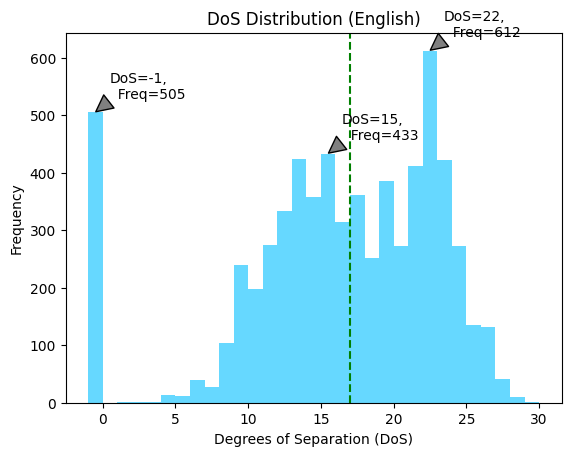

In [14]:

plot_dos(en, get_median(en))
print(f'Median = {get_median(en):.1f}')
print(f'\nAccounting for pages that did not reach Philosophy (DoS = -1), '
      f'the median is \033[1m{get_median(en):.1f}\033[0m (dashed green line in the plot).')
print(f'In the histogram, there are three observed peaks - '
      f'at DoS = -1 (did not converge to Philosophy), '
      f'and at DoS = 15 and 22 (resembling a nearly bi-modal distribution).')

#### 2. Pages with DoS = 6

In [23]:
df6, n6, nt, p6 = get_query(en, 'DoS == 6')
print(f'In total, {n6} random pages have DoS = 6, which is \033[1m{p6:.2%}\033[0m of the {nt} English Wikipedia random pages crawled.')
display(df6.head())

In total, 40 random pages have DoS = 6, which is 0.61% of the 6590 English Wikipedia random pages crawled.


,Start,DoS,Path,Msg
221,"/wiki/RMIT_School_of_Civil,_Environmental_and_...",6.0,['https://en.wikipedia.org/wiki/RMIT_School_of...,OK - short path at /wiki/Tertiary_education (l...
270,/wiki/The_Journal_of_Neuropsychiatry_and_Clini...,6.0,['https://en.wikipedia.org/wiki/The_Journal_of...,OK - short path at /wiki/Knowledge (last idx: 3).
441,/wiki/Ernst_Boepple,6.0,['https://en.wikipedia.org/wiki/Ernst_Boepple'...,OK - normal path.
725,/wiki/46_(number),6.0,"['https://en.wikipedia.org/wiki/46_(number)', ...",OK - short path at /wiki/Mathematics (last idx...
845,/wiki/The_German_Quarterly,6.0,['https://en.wikipedia.org/wiki/The_German_Qua...,OK - short path at /wiki/Field_of_study (last ...


<h7> According to [en.wikipedia](https://en.wikipedia.org/wiki/Wikipedia:Size_of_Wikipedia), there are a total of 6,823,122 English Wiki articles as of May 2024. </h7>

In [24]:
n_en = 6823122
print(f"From our results, the estimated number of English Wiki articles with DoS = 6 is \033[1m{n_en * p6:.0f}\033[0m.")

From our results, the estimated number of English Wiki articles with DoS = 6 is 41415.


#### 3. Spanish Wikipedia Results

Datapoints loaded: 5350

A total of 5350 Spanish Wikipedia random pages have been crawled.
In total, 4243 random pages converged to Psicología, which is 79.31% of the 5350 random pages crawled.
We will see in section 3.a that Psicología is the most common page where other pages gravitate to.


,Start,DoS,Path,Msg
0,/wiki/Man_and_Woman_(TV_series),10.0,['https://en.wikipedia.org/wiki/Man_and_Woman_...,OK - short path at /wiki/Language (last idx: 4).
1,/wiki/Parviz_Nouri,14.0,"['https://en.wikipedia.org/wiki/Parviz_Nouri',...",OK - short path at /wiki/Capital_city (last id...
2,"/wiki/Ste._Rita,_Manitoba",16.0,"['https://en.wikipedia.org/wiki/Ste._Rita,_Man...",OK - short path at /wiki/Unincorporated_area (...
3,/wiki/Konstantinos_Vlachopoulos,22.0,['https://en.wikipedia.org/wiki/Konstantinos_V...,OK - short path at /wiki/Military_organization...
4,/wiki/Gopalnagar_railway_station,18.0,['https://en.wikipedia.org/wiki/Gopalnagar_rai...,OK - short path at /wiki/Means_of_transport (l...


Median = 12.0

Accounting for pages that did not reach Psicología (DoS = -1), the median is 12.0 (dashed green line in the plot).
In the histogram, there are three observed peaks - at DoS = -1 (did not converge to Psicología),
and at DoS = 8 and 16 (resembling a bi-modal distribution similar with the English results).


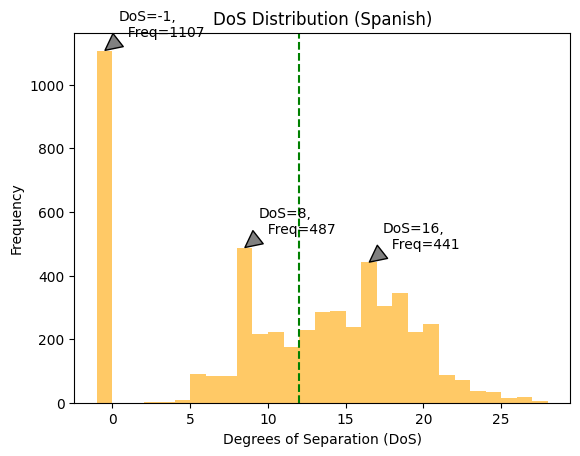

In [25]:
es = load_data(f'es_conso')
print(f'\nA total of \033[1m{es.shape[0]}\033[0m Spanish Wikipedia random pages have been crawled.')
_, nsuccess, ntotal, p = get_query(es, 'DoS != -1')
print(f'In total, {nsuccess} random pages converged to Psicología, which is \033[1m{p:.2%}\033[0m of the {ntotal} random pages crawled.')
print(f'We will see in section 3.a that \033[1mPsicología\033[0m is the most common page where other pages gravitate to.')
display(en.head())

plot_dos(es, get_median(es), 'es')
print(f'Median = {get_median(es)}')
print(f'\nAccounting for pages that did not reach Psicología (DoS = -1), '
      f'the median is \033[1m{get_median(es)}\033[0m (dashed green line in the plot).')
print(f'In the histogram, there are three observed peaks - '
      f'at DoS = -1 (did not converge to Psicología),\n'
      f'and at DoS = 8 and 16 (resembling a bi-modal distribution similar with the English results).')


<h7> According to [es.wikipedia](https://es.wikipedia.org/wiki/Wikipedia_en_espa%C3%B1ol), there are a total of 1,953,141 Spanish Wiki articles as of access date May 2024. </h7>

In [26]:
df6, n6, nt, p6 = get_query(es, 'DoS == 6')
n_es = 1953141
print(f'In total, {n6} random pages have DoS = 6, which is \033[1m{p6:.2%}\033[0m of the {nt} Spanish Wikipedia random pages crawled.')
print(f"As there are {n_es} articles in Spanish Wikipedia, an estimated \033[1m{n_es * p6:.0f}\033[0m articles have DoS = 6.")
display(df6.head())

In total, 84 random pages have DoS = 6, which is 1.57% of the 5350 Spanish Wikipedia random pages crawled.
As there are 1953141 articles in Spanish Wikipedia, an estimated 30666 articles have DoS = 6.


,Start,DoS,Path,Msg
45,/wiki/Gautschi%27s_inequality,6.0,['https://en.wikipedia.org/wiki/Gautschi%27s_i...,OK - short path at /wiki/Mathematics (last idx...
56,/wiki/Oxford_Studies_in_Ancient_Philosophy,6.0,['https://en.wikipedia.org/wiki/Oxford_Studies...,OK - short path at /wiki/Knowledge (last idx: 3).
182,/wiki/Minkowski_problem,6.0,['https://en.wikipedia.org/wiki/Minkowski_prob...,OK - short path at /wiki/Mathematics (last idx...
357,/wiki/Dixons_Croxteth_Academy,6.0,['https://en.wikipedia.org/wiki/Dixons_Croxtet...,OK - short path at /wiki/Education (last idx: 2).
439,/wiki/Canadian_Society_for_Civil_Engineering,6.0,['https://en.wikipedia.org/wiki/Canadian_Socie...,OK - short path at /wiki/Professional_organiza...


#### 3.a Most Common Page (that other pages tend to gravitate to)

In [105]:
from itertools import chain
from collections import Counter

es_paths = list(chain.from_iterable(es['Path']))
es_counts = Counter(es_paths)

print(f'Most common page visited: {es_counts.most_common(1)[0][0]}')

Most common page visited: i


#### 3.b Looping (Spanish vs English)

In [106]:
en_loop = en[en['Msg'].str.contains('looped')]
print(f'EN Loop:{en_loop.shape[0]}')

es_loop = es[es['Msg'].str.contains('looped')]
print(f'ES Loop:{es_loop.shape[0]}')

EN Loop:139
ES Loop:117


Yes, foreign language ES tends to loop more than EN when using our sample data as basis.

#### 3.c DoS (Spanish vs English)

From the density plot, the Spanish DoS distribution is shifted more to the left than the English DoS distribution.
Both the Spanish median (12.0) and mean (10.9) are also lesser than the English median (17.0) and mean (15.8), respectively.
One of the primary reasons is because Spanish Wikipedia has much fewer articles (at 1953141) than English Wikipedia (at 6823122).
So we expect that it takes fewer steps to reach the target page.


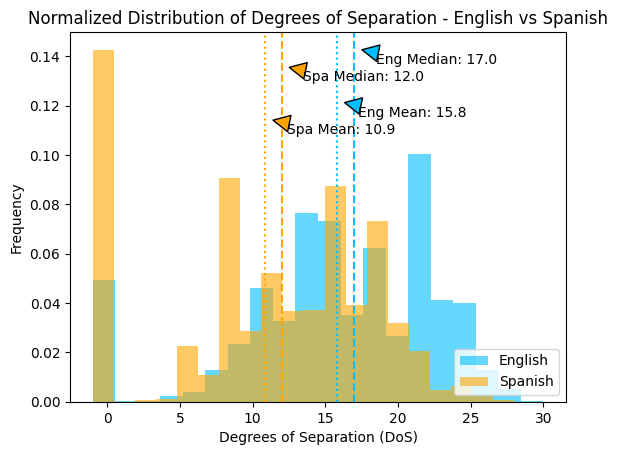

In [27]:
print(f'From the density plot, the Spanish DoS distribution is shifted more to the left than the English DoS distribution.')
print(f'Both the Spanish median ({get_median(es):.1f}) and mean ({get_mean(es):.1f}) are '
      f'also lesser than the English median ({get_median(en):.1f}) and mean ({get_mean(en):.1f}), respectively.')
print(f'One of the primary reasons is because Spanish Wikipedia has much fewer articles (at {n_es}) '
      f'than English Wikipedia (at {n_en}).')
print('So we expect that it takes fewer steps to reach the target page.')
plot_compare(en, es)
